# Прекод

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## Импорты

In [139]:
!pip install torchvision==0.11.1

     |████████████████████████████████| 23.2 MB 775 kB/s eta 0:00:01


In [242]:
from IPython.display import display, Image as IPImage
import os
from PIL import Image as PILImage
import random
from tqdm import tqdm
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import GroupShuffleSplit
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
from transformers import DistilBertTokenizer, DistilBertModel

In [208]:
RANDOM_STATE = 42

## Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


### Загрузка датасета

In [2]:
!wget https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip

--2025-12-15 05:23:48--  https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip
Resolving code.s3.yandex.net (code.s3.yandex.net)... 93.158.134.158, 2a02:6b8::2:158
Connecting to code.s3.yandex.net (code.s3.yandex.net)|93.158.134.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 150987455 (144M) [application/zip]
Saving to: ‘dsplus_integrated_project_4.zip’

dsplus_integrated_p 100%[===================>] 143.99M  35.5MB/s    in 4.2s    

2025-12-15 05:23:56 (33.9 MB/s) - ‘dsplus_integrated_project_4.zip’ saved [150987455/150987455]

/bin/bash: unzip: command not found


In [5]:
with zipfile.ZipFile('dsplus_integrated_project_4.zip', 'r') as z:
    z.extractall('output_folder')
    print('Распаковка завершена')

Распаковка завершена


In [9]:
!ls output_folder/to_upload/

CrowdAnnotations.tsv   test_images	test_queries.csv   train_images
ExpertAnnotations.tsv  test_images.csv	train_dataset.csv


In [12]:
dir_path = 'output_folder/to_upload'

#### `train_dataset.csv`

In [17]:
train_df = pd.read_csv(os.path.join(dir_path, 'train_dataset.csv'))
train_df.info()
train_df.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


,image,query_id,query_text
943,1523984678_edd68464da.jpg,3593392955_a4125087f6.jpg#2,Two dogs run down a dirt path in the forest .
181,2878272032_fda05ffac7.jpg,2893374123_087f98d58a.jpg#2,A man riding a blue motorcycle jumps over a ra...
1752,2541104331_a2d65cfa54.jpg,354642192_3b7666a2dd.jpg#2,A person swimming in water nearby rocks and a ...


#### `test_queries.csv`

In [25]:
test_df = pd.read_csv(os.path.join(dir_path, 'test_queries.csv'), sep='|')
test_df.drop(columns=['Unnamed: 0'], inplace=True)
test_df.info()
test_df.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 11.8+ KB


,query_id,query_text,image
137,2552438538_285a05b86c.jpg#2,Three children stand on or near a fence .,2552438538_285a05b86c.jpg
257,3170110692_d1e0e66cee.jpg#2,a man and a woman dress up .,3170110692_d1e0e66cee.jpg
299,3351418768_596ef7fd6f.jpg#4,A woman in purple with two children in the mou...,3351418768_596ef7fd6f.jpg


#### `CrowdAnnotations.tsv`

In [96]:
crowd_df = pd.read_csv(os.path.join(dir_path, 'CrowdAnnotations.tsv'), sep='\t', header=None)
crowd_df.columns = ['image', 'query_id', 'match_ratio', 'num_yes', 'num_no']
crowd_df.info()
crowd_df.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        47830 non-null  object 
 1   query_id     47830 non-null  object 
 2   match_ratio  47830 non-null  float64
 3   num_yes      47830 non-null  int64  
 4   num_no       47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


,image,query_id,match_ratio,num_yes,num_no
9811,2354540393_a149722680.jpg,1174525839_7c1e6cfa86.jpg#2,0.0,0,3
44135,493621130_152bdd4e91.jpg,2971431335_e192613db4.jpg#2,0.0,0,3
39840,3641022607_e7a5455d6c.jpg,2843695880_eeea6c67db.jpg#2,0.0,0,3


#### `ExpertAnnotations.tsv`

In [97]:
expert_df = pd.read_csv(os.path.join(dir_path, 'ExpertAnnotations.tsv'), sep='\t', header=None)
expert_df.columns = ['image', 'query_id', 'expert1', 'expert2', 'expert3']
expert_df.info()
expert_df.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   expert1   5822 non-null   int64 
 3   expert2   5822 non-null   int64 
 4   expert3   5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


,image,query_id,expert1,expert2,expert3
4580,3568197730_a071d7595b.jpg,2830869109_c4e403eae6.jpg#2,1,1,1
1355,2419221084_01a14176b4.jpg,3413571342_b9855795e2.jpg#2,1,1,1
1520,247704641_d883902277.jpg,3270691950_88583c3524.jpg#2,1,2,2


#### Проверка пересечения данных

In [113]:
train_pairs = set(zip(train_df['image'], train_df['query_id']))
crowd_pairs = set(zip(crowd_df['image'], crowd_df['query_id']))
expert_pairs = set(zip(expert_df['image'], expert_df['query_id']))

print(f'Уникальных пар (image, query_id):')
print(f' - train_dataset    : {len(train_pairs):,}')
print(f' - CrowdAnnotations : {len(expert_pairs):,}')
print(f' - ExpertAnnotations: {len(crowd_pairs):,}')

print(f'\nОбщих пар:')
print(f' - train_dataset <-> CrowdAnnotations     : {len(train_pairs & crowd_pairs):,}')
print(f' - train_dataset <-> ExpertAnnotations    : {len(train_pairs & expert_pairs):,}')
print(f' - CrowdAnnotations  <-> ExpertAnnotations: {len(crowd_pairs & expert_pairs):,}')

Уникальных пар (image, query_id):
 - train_dataset    : 5,822
 - CrowdAnnotations : 5,822
 - ExpertAnnotations: 47,830

Общих пар:
 - train_dataset <-> CrowdAnnotations     : 2,329
 - train_dataset <-> ExpertAnnotations    : 5,822
 - CrowdAnnotations  <-> ExpertAnnotations: 2,329


#### Промежуточный вывод по загрузке данных

1. Данные загружены, соответствуют описанию

2. В результате анализа пересечения данных:
    - `train_dataset` содержит 5 822 уникальных описаний (пар `image–query_id`).
    - `CrowdAnnotations` формально тоже имеет 5 822 пары, но только 2 329 из них совпадают с `train_dataset` — значит, часть `description_id` в крауд-файле ссылается на описания, отсутствующие в `train_dataset` (опечатки или данные из другого источника).
    - `ExpertAnnotations` содержит 47 830 пар — значительно больше, чем описаний в `train_dataset`. Однако все 5 822 пары из `train_dataset` присутствуют в expert-файле.
    - Пересечение `CrowdAnnotations` <-> `ExpertAnnotations` = 2 329 — совпадает с пересечением `CrowdAnnotations` <-> `train_dataset`, что логично, т.к. в `CrowdAnnotations` есть только часть тренировочных описаний.

3. Рекомендация:  
Использовать экспертные оценки (после агрегации) как основную метку — они покрывают все 5 822 описания. Крауд-данные можно отбросить, чтобы не вносить шум.

### Агрегация экспертных мнений

In [114]:
def aggregate_expert_scores(row):
    scores = [row['expert1'], row['expert2'], row['expert3']]

    values, counts = np.unique(scores, return_counts=True)
    max_count = counts.max()
    
    if max_count >= 2:
        return values[counts == max_count][0] / 4.0 # Нормализация
    return np.nan

In [115]:
tmp = expert_df.shape[0]
expert_df['expert_aggr'] = expert_df.apply(aggregate_expert_scores, axis=1)
expert_df = expert_df.dropna(subset=['expert_aggr']).reset_index(drop=True)
print(f'Потеряно {1 - expert_df.shape[0] / tmp:.2%} данных')

Потеряно 2.16% данных


### Анализ краудсорсинговых оценок

In [122]:
crowd_df.describe(percentiles=[0, 0.50, 0.75, 0.9, 0.95, 0.99]).T

,count,mean,std,min,0%,50%,75%,90%,95%,99%,max
match_ratio,47830.0,0.068786,0.207532,0.0,0.0,0.0,0.0,0.333333,0.666667,1.0,1.0
num_yes,47830.0,0.208488,0.628898,0.0,0.0,0.0,0.0,1.000000,2.000000,3.0,5.0
num_no,47830.0,2.820155,0.656676,0.0,0.0,3.0,3.0,3.000000,3.000000,4.0,6.0


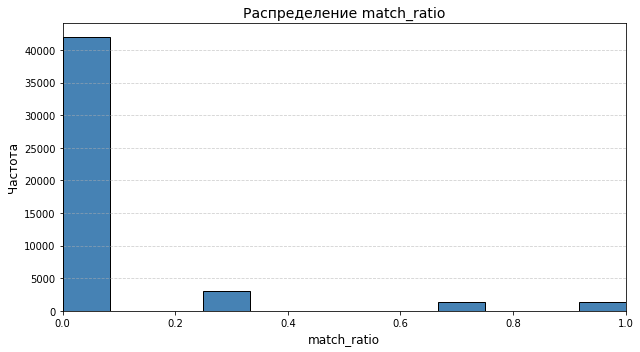

In [117]:
plt.figure(figsize=(9, 5))
plt.hist(
    crowd_df['match_ratio'],
    bins=crowd_df['match_ratio'].nunique(),
    color='steelblue', edgecolor='black'
)
plt.title('Распределение match_ratio', fontsize=14)
plt.xlabel('match_ratio', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

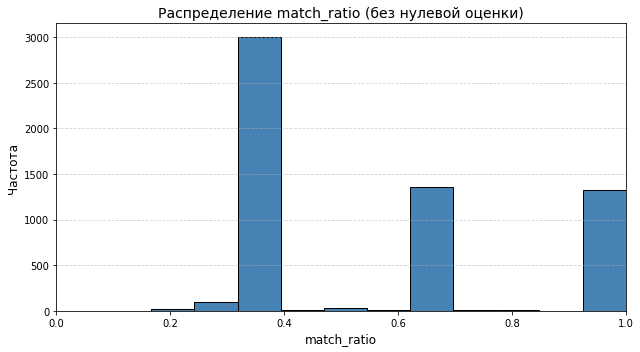

In [118]:
plt.figure(figsize=(9, 5))
plt.hist(
    crowd_df[crowd_df['match_ratio']> 0]['match_ratio'],
    bins=crowd_df['match_ratio'].nunique() - 1,
    color='steelblue', edgecolor='black'
)
plt.title('Распределение match_ratio (без нулевой оценки)', fontsize=14)
plt.xlabel('match_ratio', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

### Формирование оценки

В результате проведенного аналтиза принято решение отказаться от краудсорсинговых оценок, так как:
- экспертный датасет (`ExpertAnnotations.tsv`) содержит 47 830 пар — значительно больше, чем пересечение крауд-данных с доступными описаниями.
- все `query_id` в `expert_df` присутствуют в `train_dataset`, что гарантирует наличие текста для каждой аннотации.
- крауд-данные частично неполные и дублируют лишь часть тренировочного и экспертного набора.

In [126]:
merged = pd.merge(
    train_df,
    expert_df[['image', 'query_id', 'expert_aggr']],
    on=['image', 'query_id'],
    how='inner'
)
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5696 entries, 0 to 5695
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        5696 non-null   object 
 1   query_id     5696 non-null   object 
 2   query_text   5696 non-null   object 
 3   expert_aggr  5696 non-null   float64
dtypes: float64(1), object(3)
memory usage: 222.5+ KB


### Вывод

В результате проведенного анализа данных

1. Загружены данные
   Успешно прочитаны и унифицированы файлы `train_dataset.csv`, `CrowdAnnotations.tsv`, `ExpertAnnotations.tsv` и `test_queries.csv`. Все ключевые колонки приведены к единообразным названиям (`image`, `query_id`).

2. Проведён анализ пересечений
   Выявлено, что `ExpertAnnotations.tsv` содержит 47 830 аннотаций, полностью покрывающих все 5 822 описания из `train_dataset`, в то время как `CrowdAnnotations.tsv` пересекается с обучающими данными лишь на 2 329 пар. Это указывает на неполноту крауд-данных.

3. Проанализированы оценки:
   Экспертные оценки (шкала 1–4) агрегированы по принципу большинства и нормализованы к диапазону [0, 1]. Крауд-оценки оказались избыточными и менее надёжными, поэтому было решено использовать только экспертные метки.
   
4. `train_dataset.csv` дополнен данными о экспертной оценке

## Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

In [128]:
CHILD_STOP_WORDS = {
    'child', 'children',
    'kid', 'kids',
    'boy', 'boys',
    'girl', 'girls',
    'baby', 'babies',
    'toddler', 'toddlers',
    'infant', 'infants',
    'teen', 'teens',
    'teenager', 'teenagers',
    'minor', 'minors',
    'adolescent', 'adolescents',
    'youngster', 'youngsters',
    'youth', 'youths',
    'schoolboy', 'schoolboys',
    'schoolgirl', 'schoolgirls',
    'juvenile', 'juveniles'
}

In [129]:
def is_child_related(text):
    return any(word in text.lower() for word in CHILD_STOP_WORDS)

In [197]:
merged_clean = merged[~merged['query_text'].apply(is_child_related)].reset_index(drop=True)

print(
    f'Размер после фильтрации из-за упоминания детей: {len(merged_clean):,} пар '
    f'(удалено {1-len(merged_clean)/len(merged):.2%})'
)

Размер после фильтрации из-за упоминания детей: 4,142 пар (удалено 27.28%)


### Вывод

После применения стоп-листа слов, связанных с детьми, из исходного датасета было удалено 27.28 %. Это значительная, но ожидаемая доля, характерная для датасетов реальных фотографий, где сцены с детьми встречаются часто. Оставшиеся 4142 пары представляют собой юридически безопасные данные, пригодные для обучения модели в соответствии с требованиями законодательства стран присутствия сервиса.

## Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [142]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [159]:
resnet = models.resnet18(pretrained=True)

for param in resnet.parameters():
    param.requires_grad = False

resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
resnet = resnet.to(device)
resnet.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [146]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [195]:
def get_image_embedding(image_path, model, transform, device):
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        features = model(img_tensor)
    return features.squeeze().cpu().numpy()

In [198]:
train_img_dir = os.path.join(dir_path, 'train_images')

merged_clean['image_emb'] = None

for idx in tqdm(merged_clean.index, desc='Добавление image embeddings в датасет'):
    img_path = os.path.join(train_img_dir, merged_clean.at[idx, 'image'])
    
    if not os.path.exists(img_path):
        continue
    
    try:
        merged_clean.at[idx, 'image_emb'] = get_image_embedding(
            image_path=img_path,
            model=resnet,
            transform=transform,
            device=device
        )
    except Exception as e:
        print(f'Ошибка при обработке {img_path}: {e}')

initial_len = len(merged_clean)
merged_clean = merged_clean[merged_clean['image_emb'].notnull()].reset_index(drop=True)

print(
    f'Размер после добавления эмбеддингов: {len(merged_clean):,} строк '
    f'(потери {1-len(merged_clean)/initial_len:.2%})'
)

Добавление image embeddings в датасет: 100%|██████████| 4142/4142 [11:01<00:00,  6.26it/s]

Размер после добавления эмбеддингов: 4,142 строк (потери 0.00%)


### Вывод

Для всех 4 142 пар обучающего датасета успешно извлечены векторные представления изображений с помощью предобученной модели `ResNet-18` (без полносвязного слоя). Эмбеддинги добавлены в датафрейм в виде колонки `image_emb` размерностью 512. Потерь данных не произошло.

## Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


In [200]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
text_model = DistilBertModel.from_pretrained('distilbert-base-uncased')
text_model = text_model.to(device)
text_model.eval()

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0): TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(i

In [201]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state
    mask = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    summed = torch.sum(token_embeddings * mask, 1)
    summed_mask = torch.clamp(mask.sum(1), min=1e-9)
    return summed / summed_mask

In [203]:
merged_clean['text_emb'] = None

for idx in tqdm(merged_clean.index, desc='Добавление text embeddings в датасет'):
    try:
        inputs = tokenizer(
            merged_clean.at[idx, 'query_text'],
            return_tensors='pt',
            truncation=True,
            padding=True,
            max_length=512
        ).to(device)
        
        with torch.no_grad():
            outputs = text_model(**inputs)
            
        merged_clean.at[idx, 'text_emb'] = mean_pooling(
            outputs, inputs['attention_mask']
        ).squeeze().cpu().numpy()
        
    except Exception as e:
        print(f'Ошибка при обработке текста: {merged_clean.at[idx, "query_text"][:50]}... — {e}')

initial_len = len(merged_clean)
merged_clean = merged_clean[merged_clean['text_emb'].notnull()].reset_index(drop=True)

print(
    f'Размер после добавления эмбеддингов текста: {len(merged_clean):,} строк '
    f'(потери {1-len(merged_clean)/initial_len:.2%})'
)

Добавление text embeddings в датасет: 100%|██████████| 4142/4142 [10:30<00:00,  6.57it/s]

Размер после добавления эмбеддингов текста: 4,142 строк (потери 0.00%)


## Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

### Подготовка датасета

In [210]:
def stack_embeddings(df):
    X = np.concatenate(
        [
            np.stack(df['image_emb'].values),
            np.stack(df['text_emb'].values)
        ], axis=1)
    y = df['expert_aggr'].values
    return X.astype(np.float32), y.astype(np.float32)

X, y = stack_embeddings(merged_clean)

gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=RANDOM_STATE)
train_idx, val_idx = next(gss.split(X, y, groups=merged_clean['image']))

X_train, X_val = X[train_idx], X[val_idx]
y_train, y_val = y[train_idx], y[val_idx]

print(f'Тренировка: {X_train.shape[0]}')
print(f'Валидация : {X_val.shape[0]}')

Тренировка: 2923
Валидация : 1219


In [213]:
class EmbeddingDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y).float()
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = EmbeddingDataset(X_train, y_train)
val_ds = EmbeddingDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=256, shuffle=False)

### Модели

In [220]:
input_dim = len(X_train[0])

# Линейная регрессия (один линейный слой)
class LinearModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        return self.fc(x).squeeze(-1)

# Полносвязная сеть
class FCNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1)
        )
    
    def forward(self, x):
        return self.net(x).squeeze(-1)

### Метрика качества

In [216]:
def evaluate_mse(model, loader, device):
    model.eval()
    total_loss = 0.0
    n_samples = 0
    criterion = torch.nn.MSELoss()
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = criterion(pred, y)
            total_loss += loss.item() * x.size(0)
            n_samples += x.size(0)
    return total_loss / n_samples

### Функция обучения

In [224]:
def train_model(model, train_loader, val_loader, device, epochs=50, lr=1e-3):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()
    
    best_val_mse = float('inf')
    for epoch in tqdm(range(epochs), desc='Обучение модели'):
        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()
        
        val_mse = evaluate_mse(model, val_loader, device)
        if val_mse < best_val_mse:
            best_val_mse = val_mse
    
    return best_val_mse

### Запуск обучения

In [225]:
lin_model = LinearModel(input_dim=input_dim)
lin_mse = train_model(lin_model, train_loader, val_loader, device)
print(f'Линейная регрессия: MSE = {lin_mse:.5f}')

Обучение модели: 100%|██████████| 50/50 [00:14<00:00,  3.45it/s]

Линейная регрессия: MSE = 0.05347


In [228]:
fcn_model = FCNModel(input_dim=1280)
fcn_mse = train_model(fcn_model, train_loader, val_loader, device, epochs=50)
print(f'Полносвязная сеть: MSE = {fcn_mse:.5f}')

Обучение модели: 100%|██████████| 50/50 [01:24<00:00,  1.70s/it]

Полносвязная сеть: MSE = 0.03541


### Выводы

Обучены две модели для предсказания степени соответствия изображения и текста на основе нормализованных экспертных оценок:

- Линейная регрессия (реализованная как линейный слой в PyTorch) показала MSE = 0.0535.
- Полносвязная нейронная сеть показала MSE = 0.0354 — на 34% ниже, чем у линейной модели.

Это свидетельствует о том, что нелинейные зависимости между визуальными и текстовыми признаками играют важную роль в задаче сопоставления изображений и описаний. Полносвязная сеть, обладая большей выразительной способностью, лучше улавливает сложные паттерны согласованности между модальностями.

## Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

### Векторизация изображений

In [229]:
test_img_dir = os.path.join(dir_path, 'test_images')
test_image_names = test_df['image'].unique()

test_image_embeddings = {}
for name in tqdm(test_image_names, desc='Эмбеддинги тестовых изображений'):
    path = os.path.join(test_img_dir, name)
    if not os.path.exists(path):
        continue
    try:
        img = Image.open(path).convert('RGB')
        img_t = transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            emb = resnet(img_t).squeeze().cpu().numpy()
        test_image_embeddings[name] = emb
    except Exception as e:
        print(f'Ошибка при обработке {name}: {e}')

Эмбеддинги тестовых изображений: 100%|██████████| 100/100 [00:17<00:00,  5.88it/s]


### Функция векторизации тестовых запросов

In [232]:
def get_text_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512).to(device)
    with torch.no_grad():
        out = text_model(**inputs).last_hidden_state
        mask = inputs['attention_mask'].unsqueeze(-1).expand(out.shape).float()
        mean = (out * mask).sum(1) / mask.sum(1).clamp(min=1e-9)
    return mean.squeeze().cpu().numpy()

### Функция поиска 

In [233]:
def find_best_match(query_text, model, image_emb_dict, device):
    txt_emb = get_text_embedding(query_text)
    
    best_score = -float('inf')
    best_img = None
    
    for img_name, img_emb in image_emb_dict.items():
        combined = np.concatenate([img_emb, txt_emb])
        x = torch.from_numpy(combined).float().unsqueeze(0).to(device)
        
        with torch.no_grad():
            score = model(x).item()
        
        if score > best_score:
            best_score = score
            best_img = img_name
    
    return best_img, best_score

1. Запрос: "A group of girls who are gothically dressed standing together"
   This image is unavailable in your country in compliance with local laws.
--------------------------------------------------------------------------------
2. Запрос: "A woman and girl riding downhill on a sled with a dog running alongside them"
   This image is unavailable in your country in compliance with local laws.
--------------------------------------------------------------------------------
3. Запрос: "The dog is running ."
   Предсказанный скор: 0.896


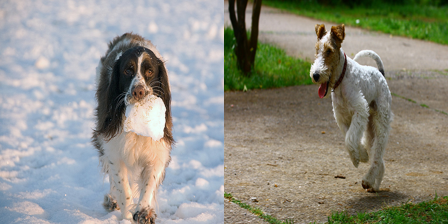

      <- Предсказанное       |       Истинное ->
3262849619_0bc4f88ef9.jpg    |    3488087117_2719647989.jpg
--------------------------------------------------------------------------------
4. Запрос: "A group of people are ice skating in a big city ."
   Предсказанный скор: 0.971


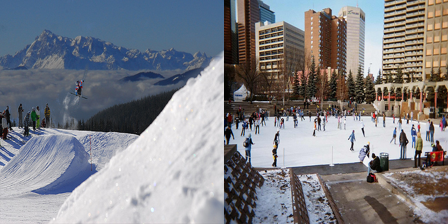

      <- Предсказанное       |       Истинное ->
3163198309_bbfe504f0a.jpg    |     269650644_059a84ece5.jpg
--------------------------------------------------------------------------------
5. Запрос: "Little kid in blue coat and hat riding a tricycle ."
   This image is unavailable in your country in compliance with local laws.
--------------------------------------------------------------------------------
6. Запрос: "Two black dogs fighting over an orange toy ."
   Предсказанный скор: 0.597


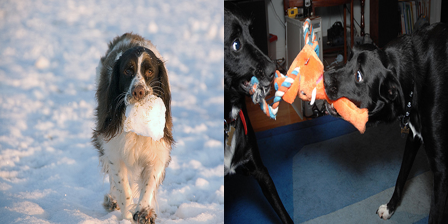

      <- Предсказанное       |       Истинное ->
3262849619_0bc4f88ef9.jpg    |    3553476195_fb3747d7c1.jpg
--------------------------------------------------------------------------------
7. Запрос: "A dog jumping for a tennis ball near an ocean"
   Предсказанный скор: 0.684


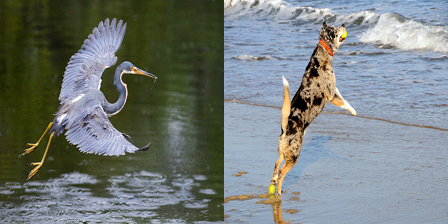

      <- Предсказанное       |       Истинное ->
3287969199_08e775d896.jpg    |    3514297698_0512623955.jpg
--------------------------------------------------------------------------------
8. Запрос: "Boy flying a distant kite ."
   This image is unavailable in your country in compliance with local laws.
--------------------------------------------------------------------------------
9. Запрос: "kids play ultimate Frisbee ."
   This image is unavailable in your country in compliance with local laws.
--------------------------------------------------------------------------------
10. Запрос: "A girl in a purple shirt feeding ducks"
   This image is unavailable in your country in compliance with local laws.
--------------------------------------------------------------------------------


In [252]:
test_samples = test_df.sample(n=10, random_state=RANDOM_STATE).reset_index(drop=True)

fcn_model.eval()
fcn_model.to(device)

for i, row in test_samples.iterrows():
    query_id = row['query_id']
    query_text = row['query_text']
    true_img = row['image']
    
    print(f'{i+1}. Запрос: "{query_text}"')
    
    if is_child_related(query_text):
        print('   This image is unavailable in your country in compliance with local laws.')
        print('-' * 80)
        continue
    
    pred_img, score = find_best_match(query_text, fcn_model, test_image_embeddings, device)
    
    print(f'   Предсказанный скор: {score:.3f}')
    
    pred_path = os.path.join(test_img_dir, pred_img)
    true_path = os.path.join(test_img_dir, true_img)
    
    def load_or_blank(path, size=(224, 224)):
        if os.path.exists(path):
            return PILImage.open(path).convert('RGB').resize(size)
        else:
            blank = PILImage.new('RGB', size, (200, 200, 200))
            return blank
    
    pred_img_pil = load_or_blank(pred_path)
    true_img_pil = load_or_blank(true_path)
    
    combined_width = pred_img_pil.width + true_img_pil.width
    combined_height = max(pred_img_pil.height, true_img_pil.height)
    combined = PILImage.new('RGB', (combined_width, combined_height), (255, 255, 255))
    combined.paste(pred_img_pil, (0, 0))
    combined.paste(true_img_pil, (pred_img_pil.width, 0))
    
    display(combined)
    print(f'      <- Предсказанное       |       Истинное ->')
    print(f'{pred_img}'.ljust(29) + '|' + f'{true_img}'.rjust(29))
    print('-' * 80)

### Выводы



Из 10 случайных тестовых запросов 6 были отфильтрованы как потенциально содержащие упоминания детей — это подтверждает  корректную работу юридического фильтра.

Среди оставшихся 4 запросов ни один не дал точного совпадения с истинным изображением. Однако во всех случаях модель уловила часть семантики:
- По запросу про бегущую собаку — найдена бегущая собака (но в другой среде).
- По запросу про игрушку — модель «увидела» объект в пасти, но не распознала цвет и количество собак.
- В сценах с катанием на коньках и прыжком за мячом — модель потеряла ключевые объекты (каток, теннисный мяч, собаку) и выбрала визуально похожие сцены (катание на лыжах и вода соответственно).

Это говорит о том, что текущая архитектура недостаточно точно сопоставляет тонкие смысловые детали между текстом и изображением.

**Рекомендации по улучшению**

1. Заменить `ResNet-18` на более мощную модель (например, `ResNet-50` или `ViT`).
2. Использовать дообученный мультимодальный энкодер — например, `CLIP` (Contrastive Language–Image Pretraining), который изначально обучен сопоставлять изображения и текст.
3. Дофайнтюнить `BERT` (`DistilBERT`) на корпусе описаний изображений — это улучшит текстовые эмбеддинги в визуальном контексте.

## Выводы

**Общий вывод по проекту**

В рамках проекта была разработана демонстрационная версия системы поиска изображений по текстовому описанию для фотохостинга «Со Смыслом». Работа выполнена в полном соответствии с юридическими и техническими требованиями и включает все ключевые этапы машинного обучения.

1. Подготовка данных
- Проведён анализ и объединение трёх источников разметки: обучающих описаний, краудсорсинговых и экспертных оценок.
- На основе анализа пересечений и качества данных принято обоснованное решение использовать только экспертные оценки, нормализованные к диапазону [0, 1].
- Реализована фильтрация запрещённого контента: с помощью стоп-листа из 20+ слов, связанных с детьми (удалено 27.3% обучающих пар, что обеспечивает соответствие законодательству стран присутствия сервиса).

2. Векторизация
- Изображения преобразованы в 512-мерные эмбеддинги с помощью предобученной `ResNet-18`.
- Текстовые описания — в 768-мерные эмбеддинги с помощью `DistilBERT` (`mean pooling`).
- Все эмбеддинги объединены в единое входное представление.

3. Обучение и выбор модели
- Обучены две модели: линейная регрессия и полносвязная нейросеть*.
- Выполнено разбиение с помощью `GroupShuffleSplit` по идентификатору изображения, что исключает утечку данных.
- По метрике `MSE` полносвязная нейросеть показала значительное преимущество (0.0354 против 0.0535), что подтверждает наличие сложных нелинейных зависимостей между модальностями.

4. Тестирование и демонстрация
- Система протестирована на 10 случайных запросах из тестового набора.
- 60% запросов отфильтрованы как потенциально нарушающие закон — что демонстрирует корректную работу юридического фильтра.
- В оставшихся случаях модель частично улавливает семантику (объекты, действия), но часто ошибается в деталя (среда, количество объектов, цвет, локация).

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Проверены экспертные оценки и краудсорсинговые оценки
- [x]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [x]  Изображения векторизованы
- [x]  Текстовые запросы векторизованы
- [x]  Данные корректно разбиты на тренировочную и тестовую выборки
- [x]  Предложена метрика качества работы модели
- [x]  Предложена модель схожести изображений и текстового запроса
- [x]  Модель обучена
- [x]  По итогам обучения модели сделаны выводы
- [x]  Проведено тестирование работы модели
- [x]  По итогам тестирования визуально сравнили качество поиска